In [84]:
import warnings
warnings.simplefilter("ignore")

import torch
import torch.nn.functional as functional
from torchmetrics.functional import accuracy
import torchvision
import torchvision.transforms as transforms
import numpy as np

import pytorch_lightning as pl

In [85]:
# cargamos datos de entrenamiento y test
mu = 0.1307
sig = 0.3081

mnist_train = torchvision.datasets.MNIST('../data',
                                        train = True, 
                                        download = True, 
                                        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mu, sig)])
                                        )
mnist_test = torchvision.datasets.MNIST('../data',
                                        train = False, 
                                        download = True, 
                                        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mu, sig)])
                                        )
dataloader = {
    'train': torch.utils.data.DataLoader(mnist_train, batch_size = 1024, shuffle = True),
    'test': torch.utils.data.DataLoader(mnist_test, batch_size = 1024, shuffle = False)   
}

In [86]:
# creamos el bloque convolucional a partir de la clase Sequential de pytorch

def cnn_block(c_in, c_out, kernel=3, pad=1, stride=1, pool_kernel=2, pool_stride=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, kernel, padding = pad, stride = stride),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pool_kernel, stride = pool_stride)
    )

In [87]:
class CNN_model(pl.LightningModule):

    def __init__(self, n_channels=1, n_outputs=10):
        super().__init__()
        self.conv1 = cnn_block(n_channels, 64)
        self.conv2 = cnn_block(64, 128)
        self.fc = torch.nn.Linear(128*7*7, n_outputs)
    
    # paso hacia delante
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    # paso de entrenamiento de la red
    def training_step(self, batch, bach_idx):
        x, y = batch
        y_pred = self(x)
        loss = functional.cross_entropy(y_pred, y)
        self.log('loss', loss)
        return loss
    
    # paso de testeo
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = functional.cross_entropy(y_pred, y)
        acc = accuracy(y_pred, y)
        metrics = {'test acc': acc, 'test loss': loss }
        self.log_dict(metrics)
        return loss

    # paso de predicción
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)

    # paso de validación
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = functional.cross_entropy(y_pred, y)
        self.log('val_loss', loss, prog_bar = True)
    
    # optimizador
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 1e-3)
    
    # predictor
    def predict_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            bach_size = self.batch_size,
            num_workers = 4,
            shuffle = False
        )


In [88]:
cnn = CNN_model()

trainer = pl.Trainer(max_epochs = 2, accelerator='gpu', devices = 1)
trainer.fit(cnn, dataloader['train'], dataloader['test'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 640   
1 | conv2 | Sequential | 73.9 K
2 | fc    | Linear     | 62.7 K
-------------------------------------
137 K     Trainable params
0         Non-trainable params
137 K     Total params
0.549     Total estimated model params size (MB)


Predicting: 59it [35:47, ?it/s] [00:20<00:07,  2.48it/s, loss=0.0715, v_num=14, val_loss=0.104]
Epoch 1: 100%|██████████| 69/69 [00:27<00:00,  2.54it/s, loss=0.0678, v_num=14, val_loss=0.0565]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 69/69 [00:27<00:00,  2.54it/s, loss=0.0678, v_num=14, val_loss=0.0565]


In [89]:
trainer.test(dataloaders=dataloader['test'])

Restoring states from the checkpoint path at c:\Users\56936\Documents\PythonProyects\Neural_Networks\Pytorch\lightning_logs\version_14\checkpoints\epoch=1-step=118.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\56936\Documents\PythonProyects\Neural_Networks\Pytorch\lightning_logs\version_14\checkpoints\epoch=1-step=118.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test acc             0.982200026512146
        test loss          0.056514233350753784
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test acc': 0.982200026512146, 'test loss': 0.056514233350753784}]

In [90]:
trainer.save_checkpoint("cnn_v1.ckpt")
model = CNN_model.load_from_checkpoint("cnn_v1.ckpt")
model.eval()

CNN_model(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=6272, out_features=10, bias=True)
)

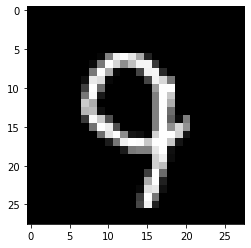

Predict: 9


In [91]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
])

import matplotlib.pyplot as plt

img = mnist_test[999][0].numpy().squeeze()
plt.imshow(img, cmap='gray')
plt.show()

input_tensor = transform(img).unsqueeze(0)
input_tensor = input_tensor.to('cuda')

model.cuda()
output = model(input_tensor)
pred = output.argmax(1, keepdim = True)

print("Predict: {}".format(pred.cpu()[0][0]))

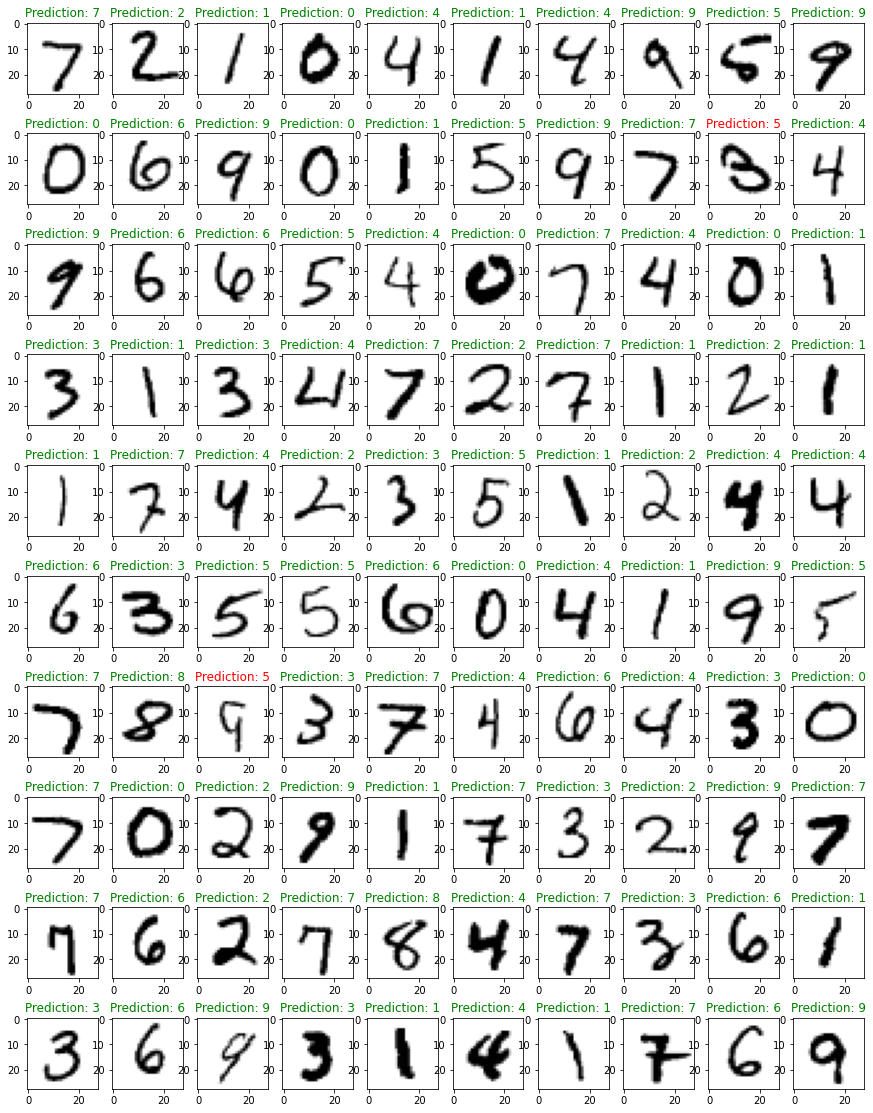

In [92]:
n_row = 10
n_col = 10

fig, axes = plt.subplots(n_row, n_col, figsize = (1.5*n_col, 2*n_row))

for i in range(n_row * n_col):
    image = mnist_test[i][0].numpy().squeeze()

    input_tensor = transform(image).unsqueeze(0)
    input_tensor = input_tensor.to('cuda')

    output = model(input_tensor)
    pred = output.argmax(1, keepdim = True).cpu()[0][0]

    label = mnist_test.test_labels[i].numpy()
    
    ax = axes[i//n_col, i % n_col]
    ax.imshow(np.reshape(image, (28,28)), cmap='gray_r')
    
    if pred.numpy() != label:
        color = 'red'
    else:
        color = 'green'
    ax.set_title('Prediction: {}'.format(pred), color = color)
plt.show()